In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
from scipy.stats import norm
from scipy.stats import multivariate_normal
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter
import copy

In [2]:
# Generate synthetic data
# components = ['level','fourrier','ar']
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 1000

AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# Set seed
np.random.seed(0)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# # ts = data_generator.generate_time_series()
# data_generator.plot()

In [3]:
# Generate periodic pattern
components_P = ['level','fourrier']

hyperparameters_P = {'level': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'observation': {'error': 0}}
x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
          'var': np.diag([0,1e-12, 1e-12])}

data_generator_P = generate_one_synthetic_time_series(components = components_P, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters_P, 
                                                    num_steps = num_steps,
                                                    x_init = x_init_P)

# # ts = data_generator.generate_time_series()
# data_generator_P.plot()

In [4]:
# Add periodic patten
data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()

# data_generator.plot()

In [5]:
# # Save data_generator.time_series['y'] to .csv
# observation_file_paths = ['data/observation.csv', 'data/dummy.csv', 'data/dummy2.csv']
# datetime_file_paths = ['data/datetime.csv', 'data/dummy_datetime.csv', 'data/dummy_datetime2.csv']
# start_date = datetime(2000, 1, 1)
# indices_train_val_test = [1000, -1, -1]
# data_generator.time_step_interval = 7
# data_generator.export_to_csv(indices_train_val_test, observation_file_paths, datetime_file_paths, start_date)

In [6]:
######################################## Base model ########################################
components = ['trend','fourrier', 'ar']
# components = ['trend', 'ar']

hyperparameters = {'trend': {'process_error_var': 0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
# x_init = {'mu': np.array([5, 0.0, -0.0621]), \
#           'var': np.diag([1e-12, 1E-12, 6.36E-05])}
x_init = {'mu': np.array([5, 0.0, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
          'var': np.diag([1e-12, 1E-12,1e-12, 1E-12, 6.36E-05])}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)

######################################## Meta-AR model ########################################
components_d = ['trend', 'ar']

# expected_detection_time = 52 * 3
# baseline_process_error_var = AR_stationary_var / 1e7
baseline_process_error_var = 1e-6

hyperparameters_d = {'trend': {'process_error_var': baseline_process_error_var, 'phi': 1},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init_d = {'mu': np.array([0, 0.0, -0.0621]), \
          'var': np.diag([1e-12, 1e-12, 6.36E-05])}

kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)

# Anomaly settings
anm_pos = 200
anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
# anm_mag = 0

# Trigger settings
# Randomly generate 500 numbers between 0 and 1000
# trigger_pos = np.random.randint(0, 1000, 500).tolist()
# trigger_pos = [500, 600]
trigger_pos = []


## Utils

In [7]:
def _get_look_back_time_steps(current_step, step_look_back=0):
    look_back_step_list = [0]
    current = 1
    while current <= step_look_back:
        look_back_step_list.append(current)
        current *= 2
    look_back_step_list = [current_step - i for i in look_back_step_list]

    return look_back_step_list

def _hidden_states_collector(current_step, hidden_states_all_step_mu, hidden_states_all_step_var):
        hidden_states_all_step_numpy = {'mu': np.array(hidden_states_all_step_mu), \
                                  'var': np.array(hidden_states_all_step_var)}
        look_back_steps_list = _get_look_back_time_steps(current_step)
        hidden_states_collected = {'mu': hidden_states_all_step_numpy['mu'][look_back_steps_list], \
                                    'var': hidden_states_all_step_numpy['var'][look_back_steps_list]}
        return hidden_states_collected

def estimate_hs_distribution(num_ts = 10):
    # Collect samples
    ARd_samples = []
    LLd_samples = []
    LTd_samples = []
    x_samples = []
    for i in range(num_ts):
        np.random.seed(10+i)

        data_generator_i = generate_one_synthetic_time_series(components = components, 
                                                            time_step_interval = time_step_interval, 
                                                            hyperparameters = hyperparameters, 
                                                            num_steps = num_steps,
                                                            x_init = x_init)

        ############## Run two models ################
        x_last_step = x_init
        x_last_step_d = x_init_d
        LLd_mu, LTd_mu, ARd_mu = [], [], []
        LLd_var, LTd_var, ARd_var = [], [], []
        for i in range(num_steps):
            ############ Base model ############
            y_pred, x_pred, _ = kf.predict(x_last_step)
            x_updated, _, _ = kf.update(data_generator_i.time_series['y'][i])

            ############ Meta-AR model ############
            pred_AR, xd_pred, _ = kf_d.predict(x_last_step_d)
            pred_AR['mu'] = pred_AR['mu'].item()
            pred_AR['var'] = pred_AR['var'].item()

            # Smoother equations to update
            target_AR = {'mu': x_pred['mu'][-1], 'var': x_pred['var'][-1,-1]}
            cov_x_AR = xd_pred['var'] @ kf_d.F.T
            xd_updated = kf_d.dist_update(target_AR, pred_AR, xd_pred, cov_x_AR)

            x_last_step = x_updated
            x_last_step_d = xd_updated

            LLd_mu.append(xd_pred['mu'][0])
            LTd_mu.append(xd_pred['mu'][1])
            ARd_mu.append(xd_pred['mu'][-1])
            LLd_var.append(xd_pred['var'][0,0])
            LTd_var.append(xd_pred['var'][1,1])
            ARd_var.append(xd_pred['var'][-1,-1])

            if i > 64:
                ARd_history = _hidden_states_collector(-1, ARd_mu, ARd_var)
                ARd_samples.append(ARd_history['mu'].tolist())
                LLd_history = _hidden_states_collector(-1, LLd_mu, LLd_var)
                LLd_samples.append(LLd_history['mu'].tolist())
                LTd_history = _hidden_states_collector(-1, LTd_mu, LTd_var)
                LTd_samples.append(LTd_history['mu'].tolist())
                x_samples.append(LTd_history['mu'].tolist())

    ARd_samples = np.array(ARd_samples)
    LLd_samples = np.array(LLd_samples)
    LTd_samples = np.array(LTd_samples)
    x_samples = np.array(x_samples)

    # Estimate the distribution of the collected samples
    ARd_samples_mean = np.mean(ARd_samples, axis=0)
    LLd_samples_mean = np.mean(LLd_samples, axis=0)
    LTd_samples_mean = np.mean(LTd_samples, axis=0)
    # ARd_samples_std = np.std(ARd_samples, axis=0)
    # Compute covariance
    ARd_samples_cov = np.cov(ARd_samples.T)
    LLd_samples_cov = np.cov(LLd_samples.T)
    LTd_samples_cov = np.cov(LTd_samples.T)

    # # Stack the samples together
    # x_samples_mean = np.hstack((LLd_samples_mean, LTd_samples_mean, ARd_samples_mean))
    # x_samples_cov = np.block([[LLd_samples_cov, np.zeros((8,8)), np.zeros((8,8))],
    #                           [np.zeros((8,8)), LTd_samples_cov, np.zeros((8,8))],
    #                           [np.zeros((8,8)), np.zeros((8,8)), ARd_samples_cov]])
    
    x_samples_mean = np.mean(x_samples, axis=0)
    x_samples_cov = np.cov(x_samples.T)


    return x_samples_mean, x_samples_cov

In [8]:
x_samples_mean, x_samples_cov = estimate_hs_distribution()
print(x_samples_mean, x_samples_cov)

[0.00026317] 4.728058038118972e-05


## Observation likelihood

In [9]:
# ############## Run two models ################
# x_last_step = x_init
# x_last_step_d = x_init_d
# LL_mu, LT_mu, AR_mu = [], [], []
# LL_var, LT_var, AR_var = [], [], []
# LLd_mu, LTd_mu, ARd_mu = [], [], []
# LLd_var, LTd_var, ARd_var = [], [], []
# y_pred_mus, y_pred_vars = [], []
# y_pred_mus_d, y_pred_vars_d = [], []
# total_reward = 0
# rewards_obs = []
# LT_reference = None
# for i in range(num_steps):
#     # Add anomaly 
#     if i >= anm_pos:
#         data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
#         # data_generator.time_series['y'][i] += anm_mag
    
#     ############ Base model ############
#     if i+1 in trigger_pos:
#         LT_reference = x_last_step['mu'][1]

#         # Assign the drrift hidden states to the base ones
#         x_last_step['mu'][0] += x_last_step_d['mu'][0]
#         x_last_step['mu'][1] += x_last_step_d['mu'][1]
#         x_last_step['var'][0,0] += x_last_step_d['var'][0,0]
#         x_last_step['var'][1,1] += x_last_step_d['var'][1,1]
#         # x_last_step['var'][1,1] += 0.01
#         x_last_step['mu'][-1] = x_last_step_d['mu'][-1]
#         x_last_step['var'][-1,-1] = x_last_step_d['var'][-1,-1]
#         x_last_step_d = x_init_d

#     y_pred, x_pred, _ = kf.predict(x_last_step)
#     x_updated, likelihood, _ = kf.update(data_generator.time_series['y'][i])

#     # Define reward
#     reward = likelihood

#     # # Penalties
#     # if LT_reference is not None:
#     #     reward -= 1 * norm.pdf(LT_reference, loc=x_last_step['mu'][1], scale=np.sqrt(x_last_step['var'][1,1])) \
#     #                     /norm.pdf(x_last_step['mu'][1], loc=x_last_step['mu'][1], scale=np.sqrt(x_last_step['var'][1,1]))

#     rewards_obs.append(reward)

#     ############ Meta-AR model ############
#     pred_AR, xd_pred, _ = kf_d.predict(x_last_step_d)
#     pred_AR['mu'] = pred_AR['mu'].item()
#     pred_AR['var'] = pred_AR['var'].item()

#     # Smoother equations to update
#     target_AR = {'mu': x_pred['mu'][-1], 'var': x_pred['var'][-1,-1]}
#     cov_x_AR = xd_pred['var'] @ kf_d.F.T
#     xd_updated = kf_d.dist_update(target_AR, pred_AR, xd_pred, cov_x_AR)

#     x_last_step = x_updated
#     x_last_step_d = xd_updated

#     LL_mu.append(x_pred['mu'][0])
#     LT_mu.append(x_pred['mu'][1])
#     AR_mu.append(x_pred['mu'][-1])
#     LL_var.append(x_pred['var'][0,0])
#     LT_var.append(x_pred['var'][1,1])
#     AR_var.append(x_pred['var'][-1,-1])
#     y_pred_mus.append(y_pred['mu'].item())
#     y_pred_vars.append(y_pred['var'].item())

#     LLd_mu.append(xd_pred['mu'][0])
#     LTd_mu.append(xd_pred['mu'][1])
#     ARd_mu.append(xd_pred['mu'][-1])
#     LLd_var.append(xd_pred['var'][0,0])
#     LTd_var.append(xd_pred['var'][1,1])
#     ARd_var.append(xd_pred['var'][-1,-1])
#     y_pred_mus_d.append(pred_AR['mu'])
#     y_pred_vars_d.append(pred_AR['var'])


In [10]:
# # Plot prediction
# plt.rcParams["figure.autolayout"] = True
# fig = plt.figure(figsize=(12, 10))
# gs = gridspec.GridSpec(7, 1)
# ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[2])
# ax2 = plt.subplot(gs[3])
# ax3 = plt.subplot(gs[4])
# ax4 = plt.subplot(gs[5])
# ax5 = plt.subplot(gs[6])
# ax6 = plt.subplot(gs[1])

# ############ Base model ############
# ax0.plot(data_generator.time_series['timesteps'], y_pred_mus, label='Prediction')
# ax0.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus)-np.sqrt(y_pred_vars), np.array(y_pred_mus)+np.sqrt(y_pred_vars),color='gray', alpha=0.2)
# ax0.plot(data_generator.time_series['timesteps'], LL_mu, 'k--')
# ax0.fill_between(data_generator.time_series['timesteps'], np.array(LL_mu)-np.sqrt(LL_var), np.array(LL_mu)+np.sqrt(LL_var),color='gray', alpha=0.2)
# ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
# if anm_mag != 0:
#     ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
# if len(trigger_pos) > 0:
#     for trigger in trigger_pos:
#         ax0.axvline(x=trigger, color='k', linestyle='--')
# ax0.legend(loc='upper left', ncol = 2)
# ax0.set_ylabel('LL')
# ax0.set_title('Total reward: {}'.format(np.round(np.sum(rewards_obs), 2)))

# # Plot rewards
# ax6.plot(data_generator.time_series['timesteps'], rewards_obs, label='Reward')
# ax6.set_ylabel('Reward')

# # Plot LT
# ax1.plot(data_generator.time_series['timesteps'], LT_mu, label='LT prediction')
# ax1.fill_between(data_generator.time_series['timesteps'], np.array(LT_mu)-np.sqrt(LT_var), np.array(LT_mu)+np.sqrt(LT_var),color='gray', alpha=0.2)
# ax1.set_ylabel('LT')

# # Plot AR
# ax2.plot(data_generator.time_series['timesteps'], AR_mu, label='AR prediction')
# ax2.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
# ax2.set_ylabel('AR')

# ############ Meta-AR model ############
# ax3.plot(data_generator.time_series['timesteps'], y_pred_mus_d, label='Prediction')
# ax3.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus_d)-np.sqrt(y_pred_vars_d), np.array(y_pred_mus_d)+np.sqrt(y_pred_vars_d),color='gray', alpha=0.2)
# ax3.plot(data_generator.time_series['timesteps'], LLd_mu, 'k--', label='LL prediction')
# ax3.fill_between(data_generator.time_series['timesteps'], np.array(LLd_mu)-np.sqrt(LLd_var), np.array(LLd_mu)+np.sqrt(LLd_var),color='gray', alpha=0.2)
# ax3.plot(data_generator.time_series['timesteps'], AR_mu, label='AR')
# ax3.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
# if anm_mag != 0:
#     ax3.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
# if len(trigger_pos) > 0:
#     for trigger in trigger_pos:
#         ax3.axvline(x=trigger, color='k', linestyle='--')
# ax3.set_ylabel('LLd')

# # Plot LT
# ax4.plot(data_generator.time_series['timesteps'], LTd_mu, label='LT prediction')
# ax4.fill_between(data_generator.time_series['timesteps'], np.array(LTd_mu)-np.sqrt(LTd_var), np.array(LTd_mu)+np.sqrt(LTd_var),color='gray', alpha=0.2)
# ax4.set_ylabel('LTd')

# # Plot AR
# ax5.plot(data_generator.time_series['timesteps'], ARd_mu, label='AR prediction')
# ax5.fill_between(data_generator.time_series['timesteps'], np.array(ARd_mu)-np.sqrt(ARd_var), np.array(ARd_mu)+np.sqrt(ARd_var),color='gray', alpha=0.2)
# ax5.set_ylabel('ARd')

## Hidden states likelihood

In [11]:
############## Run two models ################
x_last_step = x_init
x_last_step_d = x_init_d
LL_mu, LT_mu, AR_mu = [], [], []
LL_var, LT_var, AR_var = [], [], []
LLd_mu, LTd_mu, ARd_mu = [], [], []
LLd_var, LTd_var, ARd_var = [], [], []
y_pred_mus, y_pred_vars = [], []
y_pred_mus_d, y_pred_vars_d = [], []
total_reward = 0
rewards = []
likelihood_y_a = []
likelihood_y_na = []
likelihood_x_a = []
likelihood_x_na = []
LT_reference = None

prior_a = [0.998, 0.002]
# prior_a = [0.5, 0.5]


mv_normal_x = multivariate_normal(mean=x_samples_mean, cov=x_samples_cov, allow_singular=True)

for i in range(num_steps):
    # # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)

    # if i >= anm_pos:
    #     data_generator.time_series['y'][i] += -20

    ############## Store the x_last_step and x_last_step_d ################
    x_last_step_temp = copy.deepcopy(x_last_step)
    x_last_step_d_temp = copy.deepcopy(x_last_step_d)
    kf_dup1 = copy.deepcopy(kf)
    kf_dup2 = copy.deepcopy(kf)
    kfd_dup1 = copy.deepcopy(kf_d)
    kfd_dup2 = copy.deepcopy(kf_d)

    ############ Estimate reward ############
    # Likelihood when intervention is taken
    x_last_step['mu'][0] += x_last_step_d['mu'][0]
    x_last_step['mu'][1] += x_last_step_d['mu'][1]
    x_last_step['mu'][-1] = x_last_step_d['mu'][-1]
    x_last_step['var'][0,0] += x_last_step_d['var'][0,0]
    x_last_step['var'][1,1] += x_last_step_d['var'][1,1]
    x_last_step['var'][-1,-1] = x_last_step_d['var'][-1,-1]
    x_last_step_d = x_init_d

    # # Base model
    y_pred, x_pred, _ = kf_dup1.predict(x_last_step)
    x_updated, y_likelihood_a, _ = kf_dup1.update(data_generator.time_series['y'][i])

    # # Drift model
    pred_AR, xd_pred, _ = kfd_dup1.predict(x_last_step_d)
    pred_AR['mu'] = pred_AR['mu'].item()
    pred_AR['var'] = pred_AR['var'].item()

    target_AR = {'mu': x_pred['mu'][-1], 'var': x_pred['var'][-1,-1]}
    cov_x_AR = xd_pred['var'] @ kfd_dup1.F.T
    xd_updated = kfd_dup1.dist_update(target_AR, pred_AR, xd_pred, cov_x_AR)

    # x_likelihood_a = mv_normal_x.pdf(xd_pred['mu'][1])/mv_normal_x.pdf(x_samples_mean)
    x_likelihood_a = mv_normal_x.pdf(xd_pred['mu'][1])

    # Likelihood when intervention is not taken
    x_last_step = x_last_step_temp
    x_last_step_d = x_last_step_d_temp
    # # Base model
    y_pred, x_pred, _ = kf_dup2.predict(x_last_step)
    x_updated, y_likelihood_na, _ = kf_dup2.update(data_generator.time_series['y'][i])

    # # Drift model
    pred_AR, xd_pred, _ = kfd_dup2.predict(x_last_step_d)
    pred_AR['mu'] = pred_AR['mu'].item()
    pred_AR['var'] = pred_AR['var'].item()

    target_AR = {'mu': x_pred['mu'][-1], 'var': x_pred['var'][-1,-1]}
    cov_x_AR = xd_pred['var'] @ kfd_dup2.F.T
    xd_updated = kfd_dup2.dist_update(target_AR, pred_AR, xd_pred, cov_x_AR)

    # x_likelihood_na = mv_normal_x.pdf(xd_pred['mu'][1])/mv_normal_x.pdf(x_samples_mean)
    x_likelihood_na = mv_normal_x.pdf(xd_pred['mu'][1])

    likelihood_y_a.append(y_likelihood_a)
    likelihood_y_na.append(y_likelihood_na)
    likelihood_x_a.append(x_likelihood_a)
    likelihood_x_na.append(x_likelihood_na)

    # Define reward
    # if intervention_taken:
    #     reward = prior_a[1] * x_likelihood_a * y_likelihood_a / (prior_a[1] * x_likelihood_a * y_likelihood_a + prior_a[0] * x_likelihood_na * y_likelihood_na)
    # else:
    #     reward = prior_a[0] * x_likelihood_na * y_likelihood_na / (prior_a[1] * x_likelihood_a * y_likelihood_a + prior_a[0] * x_likelihood_na * y_likelihood_na)
    reward = prior_a[0] * x_likelihood_na * y_likelihood_na / (prior_a[1] * x_likelihood_a * y_likelihood_a + prior_a[0] * x_likelihood_na * y_likelihood_na)
    reward = 1 - reward

    ############ Base model ############
    if i+1 in trigger_pos:
    # if reward > 0.5:
        # trigger_pos.append(i)
        
        LT_reference = x_last_step['mu'][1]

        # Assign the drrift hidden states to the base ones
        # Insufficient intervention
        x_last_step['mu'][0] += x_last_step_d['mu'][0]
        x_last_step['mu'][1] += x_last_step_d['mu'][1]
        x_last_step['mu'][-1] = x_last_step_d['mu'][-1]
        x_last_step['var'][0,0] += x_last_step_d['var'][0,0]
        x_last_step['var'][1,1] += x_last_step_d['var'][1,1]
        x_last_step['var'][-1,-1] = x_last_step_d['var'][-1,-1]
        # # Perfect intervention
        # x_last_step['mu'][0] = x_init['mu'][0] + anm_mag * (i - anm_pos)
        # x_last_step['mu'][1] = x_init['mu'][1] + anm_mag
        # x_last_step['mu'][-1] -= anm_mag * (i - anm_pos)

        x_last_step_d = copy.deepcopy(x_init_d)
        x_last_step_d['mu'][-1] = x_last_step['mu'][-1]
        x_last_step_d['var'][-1,-1] = x_last_step['var'][-1,-1]

        intervention_taken = True
    else:
        intervention_taken = False

    y_pred, x_pred, _ = kf.predict(x_last_step)
    x_updated, y_likelihood, _ = kf.update(data_generator.time_series['y'][i])

    ############ Meta-AR model ############
    pred_AR, xd_pred, _ = kf_d.predict(x_last_step_d)
    pred_AR['mu'] = pred_AR['mu'].item()
    pred_AR['var'] = pred_AR['var'].item()

    # Smoother equations to update
    target_AR = {'mu': x_pred['mu'][-1], 'var': x_pred['var'][-1,-1]}
    cov_x_AR = xd_pred['var'] @ kf_d.F.T
    xd_updated = kf_d.dist_update(target_AR, pred_AR, xd_pred, cov_x_AR)

    x_last_step = x_updated
    x_last_step_d = xd_updated

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())

    LLd_mu.append(xd_pred['mu'][0])
    LTd_mu.append(xd_pred['mu'][1])
    ARd_mu.append(xd_pred['mu'][-1])
    LLd_var.append(xd_pred['var'][0,0])
    LTd_var.append(xd_pred['var'][1,1])
    ARd_var.append(xd_pred['var'][-1,-1])
    y_pred_mus_d.append(pred_AR['mu'])
    y_pred_vars_d.append(pred_AR['var'])

    # # Get the ARd history
    # if i > 64:
    #     ARd_history = _hidden_states_collector(-1, ARd_mu, ARd_var)
    #     LLd_history = _hidden_states_collector(-1, LLd_mu, LLd_var)
    #     LTd_history = _hidden_states_collector(-1, LTd_mu, LTd_var)

    #     x_history_mean = LTd_history['mu'].tolist()

    #     # Estimate the pdf at ARd_history_mean using ARd_samples_mean and ARd_samples_cov
    #     x_likelihood = mv_normal_x.pdf(x_history_mean)

    #     if len(trigger_pos) > 0 and i+1 in trigger_pos + np.arange(64):
    #         reward_x = 0
    #     else:
    #         reward_x = x_likelihood
    # else:
    #     reward_x = np.nan

    # # Penalties
    # if LT_reference is not None:
    #     reward -= 1 * norm.pdf(LT_reference, loc=x_last_step['mu'][1], scale=np.sqrt(x_last_step['var'][1,1])) \
    #                     /norm.pdf(x_last_step['mu'][1], loc=x_last_step['mu'][1], scale=np.sqrt(x_last_step['var'][1,1]))

    rewards.append(reward)

Text(0, 0.5, 'ARd')

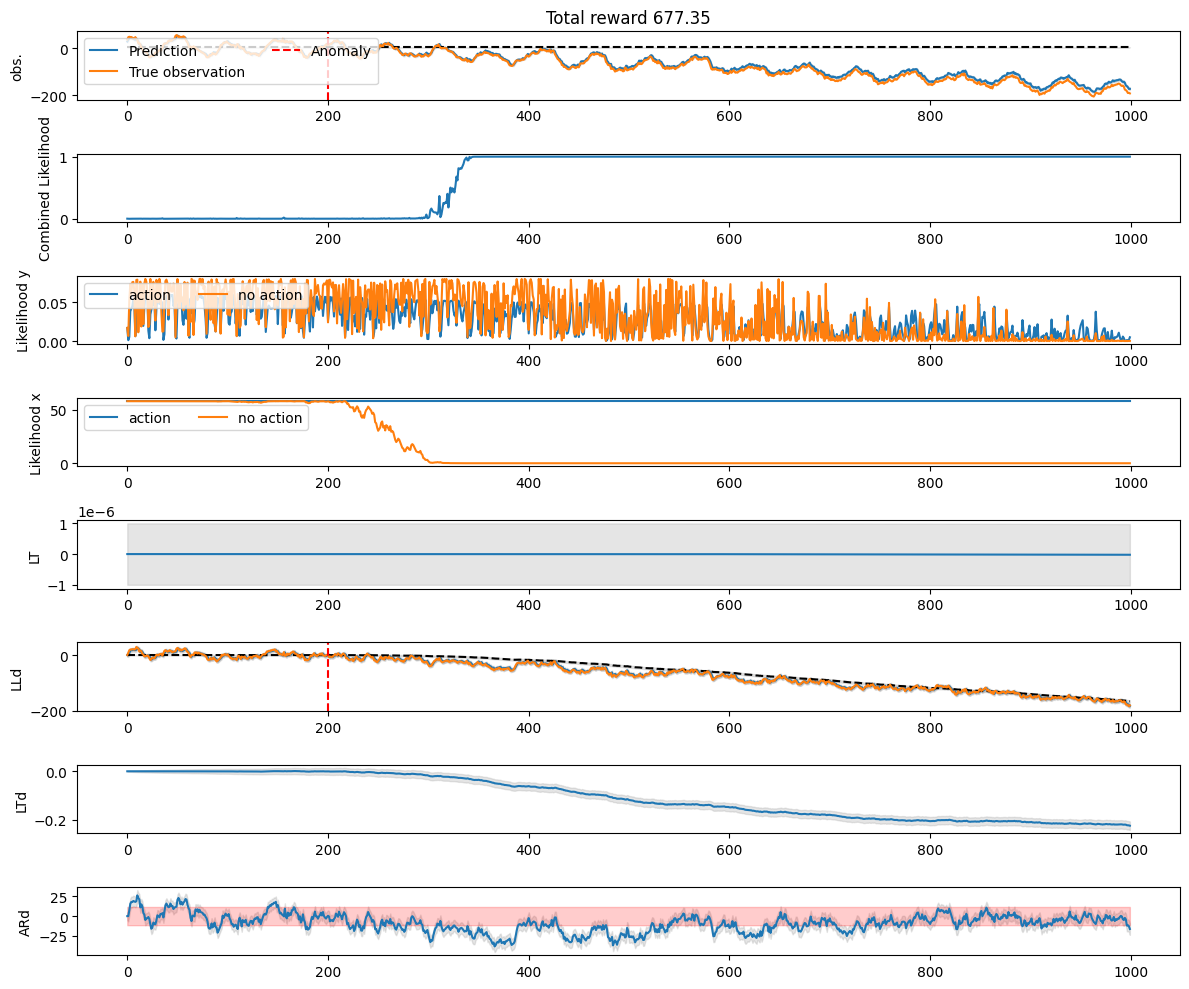

In [12]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(8, 1)
ax0 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax7 = plt.subplot(gs[2])
ax8 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[4])
ax3 = plt.subplot(gs[5])
ax4 = plt.subplot(gs[6])
ax5 = plt.subplot(gs[7])


############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], y_pred_mus, label='Prediction')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus)-np.sqrt(y_pred_vars), np.array(y_pred_mus)+np.sqrt(y_pred_vars),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], LL_mu, 'k--')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(LL_mu)-np.sqrt(LL_var), np.array(LL_mu)+np.sqrt(LL_var),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle='--')
ax0.legend(loc='upper left', ncol = 2)
ax0.set_ylabel('obs.')
# Sum the rewards that include np.nan

ax0.set_title('Total reward {}'.format(np.round(np.nansum(rewards), 2)))

# # Plot rewards
# ax6.plot(data_generator.time_series['timesteps'], likelihood_y_na, label='Reward')
# ax6.set_ylabel('L - y')
# # Use the same x-axis as ax0
# ax6.set_xlim(ax0.get_xlim())

# Plot HD LL
ax2.plot(data_generator.time_series['timesteps'], rewards, label='Combined reward')
ax2.set_ylabel('Combined Likelihood')
ax2.set_xlim(ax0.get_xlim())
ax2.set_ylim([-0.05, 1.05])

# Plot likelihood
ax7.plot(data_generator.time_series['timesteps'], likelihood_y_a, label='action')
ax7.plot(data_generator.time_series['timesteps'], likelihood_y_na, label='no action')
ax7.set_ylabel('Likelihood y')
ax7.legend(loc='upper left', ncol = 2)

# Plot likelihood
ax8.plot(data_generator.time_series['timesteps'], likelihood_x_a, label='action')
ax8.plot(data_generator.time_series['timesteps'], likelihood_x_na, label='no action')
ax8.set_ylabel('Likelihood x')
ax8.legend(loc='upper left', ncol = 2)
# ax8.set_ylim([-0.05, 1.05])

# Plot LT
ax1.plot(data_generator.time_series['timesteps'], LT_mu, label='LT prediction')
ax1.fill_between(data_generator.time_series['timesteps'], np.array(LT_mu)-np.sqrt(LT_var), np.array(LT_mu)+np.sqrt(LT_var),color='gray', alpha=0.2)
ax1.set_ylabel('LT')

############ Meta-AR model ############
ax3.plot(data_generator.time_series['timesteps'], y_pred_mus_d, label='Prediction')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus_d)-np.sqrt(y_pred_vars_d), np.array(y_pred_mus_d)+np.sqrt(y_pred_vars_d),color='gray', alpha=0.2)
ax3.plot(data_generator.time_series['timesteps'], LLd_mu, 'k--', label='LL prediction')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(LLd_mu)-np.sqrt(LLd_var), np.array(LLd_mu)+np.sqrt(LLd_var),color='gray', alpha=0.2)
ax3.plot(data_generator.time_series['timesteps'], AR_mu, label='AR')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
if anm_mag != 0:
    ax3.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax3.axvline(x=trigger, color='k', linestyle='--')
ax3.set_ylabel('LLd')

# Plot LT
ax4.plot(data_generator.time_series['timesteps'], LTd_mu, label='LT prediction')
ax4.fill_between(data_generator.time_series['timesteps'], np.array(LTd_mu)-np.sqrt(LTd_var), np.array(LTd_mu)+np.sqrt(LTd_var),color='gray', alpha=0.2)
ax4.set_ylabel('LTd')

# Plot AR
ax5.plot(data_generator.time_series['timesteps'], ARd_mu, label='AR prediction')
ax5.fill_between(data_generator.time_series['timesteps'], np.array(ARd_mu)-np.sqrt(ARd_var), np.array(ARd_mu)+np.sqrt(ARd_var),color='gray', alpha=0.2)
ax5.fill_between(data_generator.time_series['timesteps'], -np.sqrt(AR_stationary_var), np.sqrt(AR_stationary_var),color='red', alpha=0.2)
ax5.set_ylabel('ARd')

In [35]:
true_LL = np.zeros_like(LLd_mu)
true_LT = np.zeros_like(LTd_mu)
for i in range(len(LLd_mu)):
    if i > anm_pos:
        true_LL[i] = anm_mag * (i-anm_pos)
        true_LT[i] = anm_mag

sample_idx = 400
sample_history_idx_list = _get_look_back_time_steps(sample_idx, step_look_back=64) 
print(sample_history_idx_list)

[400, 399, 398, 396, 392, 384, 368, 336]


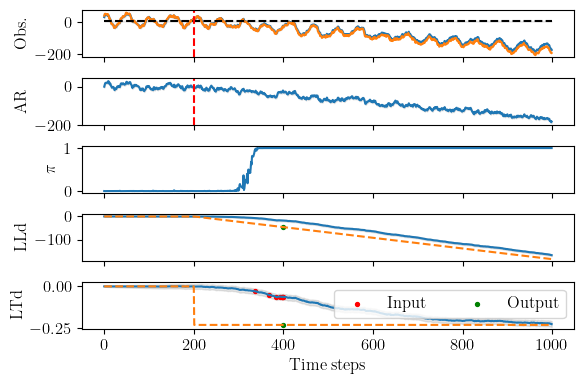

In [54]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
params = {'text.usetex' : True,
          'font.size' : 12,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 
plt.rcParams["figure.autolayout"] = True

# Plot prediction
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])


############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], y_pred_mus, label='Prediction')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus)-np.sqrt(y_pred_vars), np.array(y_pred_mus)+np.sqrt(y_pred_vars),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
ax0.plot(data_generator.time_series['timesteps'], LL_mu, 'k--')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(LL_mu)-np.sqrt(LL_var), np.array(LL_mu)+np.sqrt(LL_var),color='gray', alpha=0.2)
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle='--')
# ax0.legend(loc='upper left', ncol = 2)
ax0.set_ylabel('Obs.')
ax0.set_xticklabels([])

# # Plot likelihood-y
# ax1.plot(data_generator.time_series['timesteps'], likelihood_y_na, label=r'$\neg$ itv')
# ax1.plot(data_generator.time_series['timesteps'], likelihood_y_a, label='itv')
# ax1.set_ylabel('$\mathcal{L}^y$')
# ax1.legend(loc='upper right', ncol = 2)
# ax1.set_xticklabels([])

############ Meta-AR model ############
# ax2.plot(data_generator.time_series['timesteps'], y_pred_mus_d, label='Prediction')
# ax2.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus_d)-np.sqrt(y_pred_vars_d), np.array(y_pred_mus_d)+np.sqrt(y_pred_vars_d),color='gray', alpha=0.2)
ax1.plot(data_generator.time_series['timesteps'], AR_mu, label='AR')
ax1.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
if anm_mag != 0:
    ax1.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax1.axvline(x=trigger, color='k', linestyle='--')
ax1.set_ylabel('AR')
ax1.set_xticklabels([])

# # Plot likelihood
# ax3.plot(data_generator.time_series['timesteps'], likelihood_x_na, label=r'$\neg$ itv')
# ax3.plot(data_generator.time_series['timesteps'], likelihood_x_a, label='itv')
# ax3.set_ylabel(r'$\mathcal{L}^{LTd}$')
# ax3.legend(loc='upper right', ncol = 2)
# ax3.set_xticklabels([])

# Plot combined likelihood
ax2.plot(data_generator.time_series['timesteps'], rewards, label='Combined reward')
ax2.set_ylabel('$\pi$')
ax2.set_xlim(ax0.get_xlim())
ax2.set_ylim([-0.05, 1.05])
ax2.set_xticklabels([])

# Plot LLd
ax3.plot(data_generator.time_series['timesteps'], LLd_mu, label='Est')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(LLd_mu)-np.sqrt(LLd_var), np.array(LLd_mu)+np.sqrt(LLd_var),color='gray', alpha=0.2)
ax3.plot(data_generator.time_series['timesteps'], true_LL, '--', label='True')
# ax3.scatter(data_generator.time_series['timesteps'][sample_history_idx_list], np.array(LLd_mu)[sample_history_idx_list], color='red', label='Input')
ax3.scatter(data_generator.time_series['timesteps'][sample_idx], true_LL[sample_idx], 8, color='g', label='Output')
ax3.set_xticklabels([])
ax3.set_ylabel('LLd')

# Plot LTd
ax4.plot(data_generator.time_series['timesteps'], LTd_mu)
ax4.fill_between(data_generator.time_series['timesteps'], np.array(LTd_mu)-np.sqrt(LTd_var), np.array(LTd_mu)+np.sqrt(LTd_var),color='gray', alpha=0.2)
ax4.plot(data_generator.time_series['timesteps'], true_LT, '--')
ax4.scatter(np.array(data_generator.time_series['timesteps'])[sample_history_idx_list], np.array(LTd_mu)[sample_history_idx_list],8, color='red', label='Input')
ax4.scatter(data_generator.time_series['timesteps'][sample_idx], true_LT[sample_idx], 8, color='g', label='Output')
ax4.set_ylabel('LTd')
ax4.legend(loc='upper right', ncol = 2)
ax4.set_xlabel('Time steps')


plt.tight_layout(h_pad=0.5, w_pad=0.1)
plt.savefig('intervention.png', dpi=300)